### Import packeges

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path

In [2]:
# define ouput dir
output_dir = Path("../output/XGBoost")
output_dir.mkdir(parents=True, exist_ok=True)

output_img_dir = output_dir / "IMG"
output_img_dir.mkdir(parents=True, exist_ok=True)

output_model_dir = output_dir / "model"
output_model_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, green):
    return (nir - green) / (nir + green + 1e-10)

# Function to extract mean NDVI & NDWI as features
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, green = bands[3], bands[0], bands[1]   # Adjust based on band order
        
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, green)

        return [np.mean(ndvi), np.mean(ndwi)]  # Use mean as feature

In [4]:
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]

In [5]:
# Load dataset efficiently
train_dataset_path = Path('../../../../data/odm_dataset/Patches/Train')
test_dataset_path = Path('../../../../data/odm_dataset/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

#### Apply k-Fold Cross-Validation and GridSearchCV

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
[0]	validation_0-mlogloss:1.37864	validation_1-mlogloss:1.37974


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [17:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:1.37105	validation_1-mlogloss:1.37295
[2]	validation_0-mlogloss:1.36345	validation_1-mlogloss:1.36612
[3]	validation_0-mlogloss:1.35610	validation_1-mlogloss:1.35965
[4]	validation_0-mlogloss:1.34881	validation_1-mlogloss:1.35322
[5]	validation_0-mlogloss:1.34163	validation_1-mlogloss:1.34695
[6]	validation_0-mlogloss:1.33464	validation_1-mlogloss:1.34064
[7]	validation_0-mlogloss:1.32778	validation_1-mlogloss:1.33470
[8]	validation_0-mlogloss:1.32082	validation_1-mlogloss:1.32841
[9]	validation_0-mlogloss:1.31390	validation_1-mlogloss:1.32230
[10]	validation_0-mlogloss:1.30730	validation_1-mlogloss:1.31659
[11]	validation_0-mlogloss:1.30059	validation_1-mlogloss:1.31080
[12]	validation_0-mlogloss:1.29411	validation_1-mlogloss:1.30512
[13]	validation_0-mlogloss:1.28785	validation_1-mlogloss:1.29962
[14]	validation_0-mlogloss:1.28162	validation_1-mlogloss:1.29405
[15]	validation_0-mlogloss:1.27534	validation_1-mlogloss:1.28869
[16]	validation_0-mlogloss:1.26915

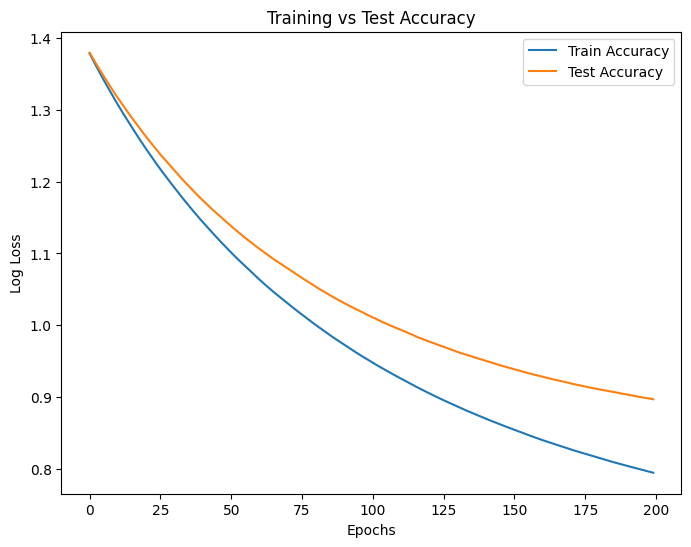

In [6]:
# Define parameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, n_jobs=-1, verbose=2, return_train_score=True)

# Train model with cross-validation
grid_search.fit(X, y)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
history = best_model.fit(X, y, eval_set=[(X, y), (X_test, y_test)], verbose=True)

# Plot training and test accuracy
eval_results = best_model.evals_result()
train_accuracy = eval_results['validation_0']['mlogloss']
test_accuracy = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.savefig(Path(os.path.join(output_img_dir, "ODM_XGB_V2_accuracy_plot.png")))
plt.show()

#### Evaluate Model

Test Accuracy: 0.5894039735099338
Test Precision: 0.5971596627061421
Test Recall: 0.5894039735099338
Test F1 Score: 0.5880409775203235
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63        97
           1       0.58      0.48      0.52        77
           2       0.50      0.73      0.59        51
           3       0.63      0.56      0.59        77

    accuracy                           0.59       302
   macro avg       0.59      0.60      0.59       302
weighted avg       0.60      0.59      0.59       302

Saved model to: ..\output\XGBoost\model\XGB_model_v2.joblib
Best Cross-Validation Accuracy: 63.48%


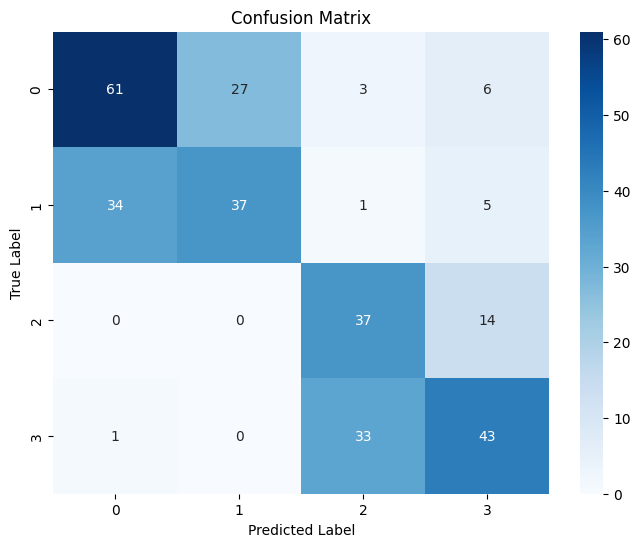

In [7]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path(os.path.join(output_img_dir, "ODM_XGB_V2_confusion_matrix.png"))) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
XGB_model_v2 = Path(os.path.join(output_model_dir, "XGB_model_v2.joblib"))
joblib.dump(best_model, XGB_model_v2)
print(f"Saved model to: {XGB_model_v2}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

#### Predict New Images

In [8]:
# Load the best model
model = joblib.load(Path(XGB_model_v2))

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../../data/odm_dataset/Patches/Train/ripening/patch_66.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")
print()

Predicted Growth Stage: ripening

